<h1 align="center"> Machine Learning: Titanic</h1><br>

<strong><p style="font-size:120%;">Assignment Prompt: </strong> Train decision tree, forests of randomized trees and Boosting trained on the Titanic Data Set. Perform and plot the decision surface for each. Don’t forget to perform data prep. (Hint: Kaggle has a nice description­ https://www.kaggle.com/c/titanic).
Perform feature importance analysis and plot histogram before the training. Several different configuration of each of the models/parameters should be explored, analyzed and plotted. Demonstrate how changes in parameters influences accuracy for different algorithms. Describe your process of parameter tuning and provide in detailed discussion of the results.  

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel

<strong><p style="font-size:120%;">Load the Dataset </strong> 

In [2]:
titanic_df = pd.read_csv("data/titanic/train.csv")

<strong><p style="font-size:120%;">Explore the dataset </strong> 

In [3]:
titanic_df.index = titanic_df.PassengerId.values

In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


<strong><p style="font-size:120%;">Missing Information </strong> It is clear that something needs to be done to deal with the missing information for the Age, Cabin, and Embarked columns.

In [5]:


# let's find the median values for Age and Fare for the missing data
titanic_df["Age"] = titanic_df["Age"].fillna(titanic_df["Age"].median())
#fill the two missing values with the most occurred value, which is "S".
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("S") 
#Since most of the cabin information is missing let's assign -1 to the rows cabin information is missing
titanic_df["Cabin"] = titanic_df["Cabin"].fillna(-1)

<strong><p style="font-size:120%;">Introducing Bias </strong> In the previous cell, I introduced bias into the model by using the mean for the missing age information. I could have used machine learning to predict the age, but for simplicity sake, I used mean. 

<strong><p style="font-size:120%;">Convert Categorical Data to Numerical Data </strong> 

In [6]:
titanic_df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [7]:
titanic_df['Sex'] = titanic_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [8]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']

In [9]:
# dropping columns. This is done in case I am testing code (drop can only be used once for a given column)

try:
    titanic_df = titanic_df.drop(['SibSp','Parch', 'Name', 'PassengerId', 'Cabin', 'Ticket', 'Fare'], axis=1)
except: 
    pass
titanic_df.head(4)

,Survived,Pclass,Sex,Age,Embarked,FamilySize
1,0,3,0,22.0,S,1
2,1,1,1,38.0,C,1
3,1,3,1,26.0,S,0
4,1,1,1,35.0,S,1


In [10]:
classes = pd.get_dummies(titanic_df['Pclass'], prefix='Class')
embarked = pd.get_dummies(titanic_df['Embarked'], prefix='Embarked')

titanic_df = pd.concat([titanic_df, classes, embarked], axis =1)

In [11]:
titanic_df.head(3)

,Survived,Pclass,Sex,Age,Embarked,FamilySize,Class_1,Class_2,Class_3,Embarked_C,Embarked_Q,Embarked_S
1,0,3,0,22.0,S,1,0.0,0.0,1.0,0.0,0.0,1.0
2,1,1,1,38.0,C,1,1.0,0.0,0.0,1.0,0.0,0.0
3,1,3,1,26.0,S,0,0.0,0.0,1.0,0.0,0.0,1.0


In [12]:
# dropping columns. This is done in case I am testing code (drop can only be used once for a given column)

try:
    titanic_df = titanic_df.drop(['Pclass','Embarked'], axis=1)
except: 
    pass

In [13]:
data = titanic_df.iloc[:, 1::]
labels = titanic_df.loc[:, ['Survived']]

In [14]:
titanic_df.columns

Index([u'Survived', u'Sex', u'Age', u'FamilySize', u'Class_1', u'Class_2',
       u'Class_3', u'Embarked_C', u'Embarked_Q', u'Embarked_S'],
      dtype='object')

/Users/mgalarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/mgalarny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


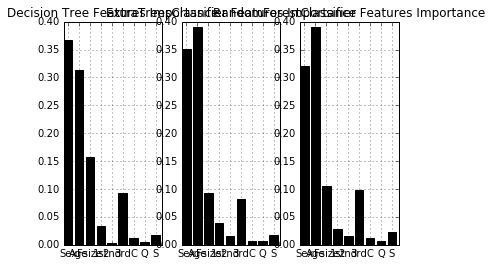

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

plt.subplot(1, 3, 1)
c = DecisionTreeClassifier().fit(data, labels)
plt.bar(range(len(c.feature_importances_)), c.feature_importances_, color=(0,0,0))
plt.xticks(np.arange(len(c.feature_importances_)) + 0.4, ['Sex', 'Age', 'Fsize', '1st', '2nd', '3rd', 'C', 'Q', 'S'])
plt.grid()
plt.title("Decision Tree Features Importance");

plt.subplot(1, 3, 2)
c = ExtraTreesClassifier().fit(data, labels)
plt.bar(range(len(c.feature_importances_)), c.feature_importances_, color=(0,0,0))
plt.xticks(np.arange(len(c.feature_importances_)) + 0.4, ['Sex', 'Age', 'Fsize', '1st', '2nd', '3rd', 'C', 'Q', 'S'])
plt.grid()
plt.title("ExtraTreesClassifier Features Importance");


plt.subplot(1, 3, 3)
c = RandomForestClassifier().fit(data, labels)
plt.bar(range(len(c.feature_importances_)), c.feature_importances_, color=(0,0,0))
plt.xticks(np.arange(len(c.feature_importances_)) + 0.4, ['Sex', 'Age', 'Fsize', '1st', '2nd', '3rd', 'C', 'Q', 'S'])
plt.grid()
plt.title("RandomForestClassifier Features Importance");